# Homework Assignment 8

**Question 1:** Select a book or a movie's subtitle, and find the locations that appear in the book/movie. Then, draw these locations on a map (at least 10 locations) (30pt). Connect the discovered locations with lines according to their order of appearance
in the book. For example, if location B appeared immediately after location A, then draw a line connecting locations A and B (20pt).

In [32]:
!pip install turicreate
!pip install spaCy
!pip install pymongo
!pip install geopandas
!pip install descartes
!pip install geopy
!pip install folium
!pip install imageio
!pip install dnspython
!pip install pyshp
!pip install folium

# Run this to make cartopy work with colab 
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip install --no-binary shapely shapely --force
!pip install afinn
!pip install nltk
!pip install plotly_express

!python -m spacy download en_core_web_lg # Important! you need to restart runtime after install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
  Using cached https://files.pythonhosted.org/packages/42/f3/0e1bc2c4f15e05e30c6b99322b9ddaa2babb3f43bc7df2698efdc1553439/Shapely-1.7.1.tar.gz
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Shapely 1.7.1
    Uninstalling Shapely-1.7.1:
      Successfully uninstalled Shapely-1.7.1
    Runnin

In [61]:
import spacy
from geopy import Nominatim
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import warnings
import operator
import turicreate as tc
import plotly_express as px
import pandas as pd
import turicreate as tc
from turicreate import aggregate as agg
import json
import shapefile
import folium
import plotly.graph_objects as go


warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [6]:
!mkdir ./datasets/tarantino
!kaggle datasets download aadityanaik/shakespeareworks -p ./datasets/tarantino
!unzip ./datasets/tarantino/*.zip  -d ./datasets/tarantino

mkdir: cannot create directory ‘./datasets/tarantino’: No such file or directory
  0% 0.00/514k [00:00<?, ?B/s]
100% 514k/514k [00:00<00:00, 36.1MB/s]
Archive:  ./datasets/tarantino/shakespeareworks.zip
  inflating: ./datasets/tarantino/django_unchained_script.txt  
  inflating: ./datasets/tarantino/inglorious_basterds_script.txt  
  inflating: ./datasets/tarantino/pulp_fiction_script.txt  
  inflating: ./datasets/tarantino/reservoir_dogs_screenplay.txt  
  inflating: ./datasets/tarantino/tarantino_scripts.txt  


In [3]:
nlp = spacy.load('en_core_web_lg')

dogs_path = './datasets/tarantino/reservoir_dogs_screenplay.txt'

def get_entites_dict_from_text(text):
    entities_dict= {}
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        e = entity.text.lower()
        if  label not in entities_dict:
            entities_dict[label] = {}
        if e not in entities_dict[label]:
            entities_dict[label][e] = 0
        entities_dict[label][e] += 1
    return entities_dict

dogs_txt = open(dogs_path,"r", encoding="utf8", errors="ignore").read()
e  = get_entites_dict_from_text(dogs_txt)
locations = list(e['GPE'])

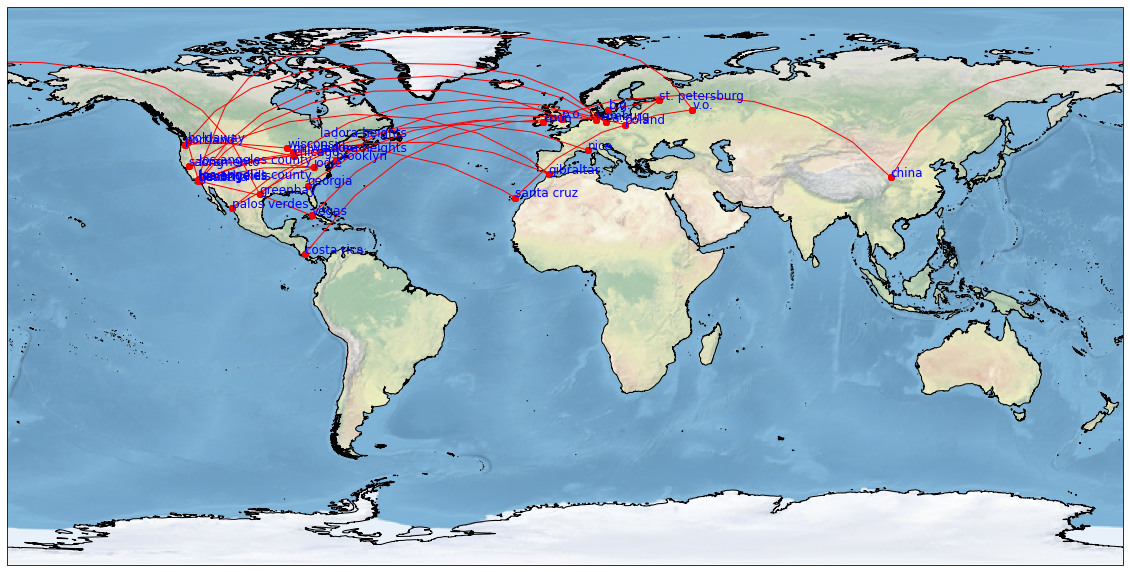

In [4]:
geolocator = Nominatim()

plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.stock_img() 

for l in locations:
    location = geolocator.geocode(l)
    if location:
        lon, lat, name =  location.longitude, location.latitude, l
        plt.plot(lon, lat,
            color='black', marker='o', markersize=6,transform=ccrs.PlateCarree(),
            )
        ax.text(lon, lat+0.2, name, fontsize=12, color="blue", transform=ccrs.PlateCarree(),)

# ax.coastlines(resolution='10m', color='black', linewidth=1)
location_index = {}
for l in locations:
    try:
        location_index[l] = dogs_txt.lower().index(l)
    except:
        pass
location_index

sorted_locations = list(sorted(location_index.items(), key=operator.itemgetter(1)))

for i in range(len(sorted_locations) - 1):
    a = geolocator.geocode(sorted_locations[i][0])
    b = geolocator.geocode(sorted_locations[i+1][0])

    if a and b:
        plt.plot([a.longitude, b.longitude], [a.latitude, b.latitude],
            color='red', linewidth=1, marker='o',
            transform=ccrs.Geodetic(),
            )

**Question 2:** Select a country's' statistic from the [World Development Indicators dataset](https://www.kaggle.com/worldbank/world-development-indicators) (Please notice there are several files in the dataset, such as _Indicators.csv_).
Then, create a choropleth map displaying how the selected statistics changed over time (15pt) 
    
**Bonus:** Create a short animation that displays how the chosen statistics changed over time (15pt)

In [5]:
!mkdir datasets/worldbank
!kaggle datasets download worldbank/world-development-indicators -p ./datasets/worldbank
!unzip ./datasets/worldbank/*.zip  -d ./datasets/worldbank/

 98% 361M/369M [00:15<00:00, 23.5MB/s]
100% 369M/369M [00:15<00:00, 24.5MB/s]
Archive:  ./datasets/worldbank/world-development-indicators.zip
  inflating: ./datasets/worldbank/Country.csv  
  inflating: ./datasets/worldbank/CountryNotes.csv  
  inflating: ./datasets/worldbank/Footnotes.csv  
  inflating: ./datasets/worldbank/Indicators.csv  
  inflating: ./datasets/worldbank/Series.csv  
  inflating: ./datasets/worldbank/SeriesNotes.csv  
  inflating: ./datasets/worldbank/database.sqlite  
  inflating: ./datasets/worldbank/hashes.txt  


In [13]:
df = pd.read_csv('./datasets/worldbank/Indicators.csv')
df.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


In [22]:
for key, val in df["IndicatorName"].value_counts().items():
  print(key, val)

Population, total 13484
Population growth (annual %) 13442
Rural population (% of total population) 13415
Urban population (% of total) 13415
Rural population 13374
Urban population 13374
Urban population growth (annual %) 13337
Surface area (sq. km) 13090
Land area (sq. km) 13086
Rural population growth (annual %) 13061
Population density (people per sq. km of land area) 12988
Death rate, crude (per 1,000 people) 12486
Birth rate, crude (per 1,000 people) 12485
Adolescent fertility rate (births per 1,000 women ages 15-19) 12485
Population, ages 0-14 (% of total) 12426
Population, ages 15-64 (% of total) 12426
Population ages 65 and above (% of total) 12426
Population, female (% of total) 12426
Age dependency ratio (% of working-age population) 12423
Age dependency ratio, old (% of working-age population) 12423
Age dependency ratio, young (% of working-age population) 12423
Life expectancy at birth, female (years) 12304
Life expectancy at birth, total (years) 12304
Life expectancy at b

In [25]:
df2 = df[df["IndicatorName"] == 'Number of infant deaths']
df2.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
1195,High income,HIC,Number of infant deaths,SH.DTH.IMRT,1960,710054.0
1654,Latin America & Caribbean (developing only),LAC,Number of infant deaths,SH.DTH.IMRT,1960,940702.0
1867,Low & middle income,LMY,Number of infant deaths,SH.DTH.IMRT,1960,11875251.0
2074,Lower middle income,LMC,Number of infant deaths,SH.DTH.IMRT,1960,5993981.0
2259,Middle East & North Africa (developing only),MNA,Number of infant deaths,SH.DTH.IMRT,1960,747144.0


In [27]:
print(" I know it's not the happiest one, but the change over world was large")

 I know it's not the happiest one, but the change over world was large


In [26]:
px.choropleth(df2, locations='CountryCode', locationmode='ISO-3', color='Value',  animation_frame='Year')

**Question 3:** Select a request type from [San Francisco 311 dataset](https://www.kaggle.com/datasf/case-data-from-san-francisco-311).
Create an interactive map that somehow presents in which areas this request occurs the most (35pt).

In [33]:
!mkdir datasets/san-francisco
!kaggle datasets download datasf/case-data-from-san-francisco-311 -p ./datasets/san-francisco
!unzip ./datasets/san-francisco/*.zip  -d ./datasets/san-francisco/

 85% 104M/122M [00:05<00:01, 10.3MB/s] 
100% 122M/122M [00:05<00:00, 22.2MB/s]
Archive:  ./datasets/san-francisco/case-data-from-san-francisco-311.zip
  inflating: ./datasets/san-francisco/Case_Data_from_San_Francisco_311__SF311.csv  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.dbf  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.prj  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.shp  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.shx  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Supervisor Districts as of April 2012/geo_export_38fd3153-0303-488e-9f3c-0f81e8e00115.dbf  
  inflating: ./datasets/san-francisco/Shapefiles (2)/Supervisor Districts as of April 2012/geo_expor

In [37]:
df = pd.read_csv('./datasets/san-francisco/Case_Data_from_San_Francisco_311__SF311.csv')
df['Request Type'].value_counts()

Bulky Items                                                          176361
Sidewalk_Cleaning                                                    171590
General Cleaning                                                     168912
Not_Offensive Graffiti on Private Property                           108168
Offensive Graffiti on Public Property                                103047
                                                                      ...  
Construction Zone Tow-away Permits for Pathway Dinwiddie                  1
redevelopment_agency - redevelopment_agency - request_for_service         1
sheriff - sheriff - followup_request                                      1
human_services_agency - waitlist_complaints - other                       1
Construction Zone Tow-away Permits for Stomper Company Inc                1
Name: Request Type, Length: 1389, dtype: int64

In [54]:
def get_lon(x):
  try:
    return float(str(x).split(',')[1].replace(')', '').replace(' ', ''))
  except:
    return None

df['lat'] = df['Point'].apply(lambda x: float(str(x).split(',')[0].replace('(', '')))
df['lon'] = df['Point'].apply(lambda x: get_lon(x))
df.dropna(inplace=True)
df.head()

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,Point,Source,Media URL,lat,lon
48971,5050169,08/31/2015 09:02:50 AM,03/14/2016 08:35:03 AM,03/14/2016 08:35:03 AM,Closed,Case Resolved - Work Order #8419 closed. Graf...,Port Authority - G,Graffiti Public Property,Offensive Graffiti on Public Property,Other_enter_additional_details_below - Offensive,Intersection of BROADWAY and THE EMBARCADERO,3.0,Northern Waterfront,"(37.7993016356325, -122.397591392155)",Open311,http://mobile311.sfgov.org/media/san_francisco...,37.799302,-122.397591
49386,5085637,09/10/2015 03:57:17 PM,03/14/2016 11:00:24 AM,03/14/2016 11:00:24 AM,Closed,Case Resolved - Service Performed.,DPT Meter_Bike Queue,Graffiti Public Property,Not_Offensive Graffiti on Public Property,Bike_rack - Not_Offensive,"4877 MISSION ST, SAN FRANCISCO, CA, 94112",11.0,Excelsior,"(37.720311024426, -122.437895757944)",Open311,http://mobile311.sfgov.org/media/san_francisco...,37.720311,-122.437896
50547,5128084,09/24/2015 11:51:51 AM,03/14/2016 11:01:04 AM,03/14/2016 11:01:04 AM,Closed,Case Resolved - Service Performed.,DPT Meter_Bike Queue,Graffiti Public Property,Not_Offensive Graffiti on Public Property,Parking_meter - Not_Offensive,Intersection of FRANCE AVE and MISSION ST,11.0,Cayuga,"(37.7200154759567, -122.438329268192)",Open311,http://mobile311.sfgov.org/media/san_francisco...,37.720015,-122.438329
65772,4906662,07/14/2015 08:17:47 AM,07/14/2015 08:50:00 AM,07/14/2015 08:50:00 AM,Closed,Case Completed - resolved:,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Intersection of KEARNY ST and VALLEJO ST,3.0,North Beach,"(37.7989693135443, -122.405645390632)",Open311,http://mobile311.sfgov.org/media/san_francisco...,37.798969,-122.405645
68204,5450261,01/10/2016 09:23:45 AM,03/14/2016 08:29:43 PM,03/14/2016 08:29:43 PM,Closed,No Response - Per process - cases are closed 6...,DPT Color Curb Queue,Color Curb,Red Color Curb Request for,Red Color Curb Request for,"204 ANDERSON ST, SAN FRANCISCO, CA, 94110",9.0,Bernal Heights,"(37.740232427476, -122.415265096681)",Web Self Service,https://311crm-prod.ad.sfgov.org/attachments/v...,37.740232,-122.415265


In [56]:
df_san_fran_gb = df.groupby(['Address', 'lat', 'lon', 'Request Type']).count()
df_san_fran_gb = df_san_fran_gb.reset_index()
df_san_fran_gb.head()

,Address,lat,lon,Request Type,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Details,Supervisor District,Neighborhood,Point,Source,Media URL
0,"1 12TH AVE, SAN FRANCISCO, CA, 94118",37.786585,-122.471302,Bulky Items,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,"1 12TH AVE, SAN FRANCISCO, CA, 94118",37.786585,-122.471302,Offensive Graffiti on Private Property,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,"1 12TH AVE, SAN FRANCISCO, CA, 94118",37.786585,-122.471302,Sign - Defaced,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,"1 14TH ST, SAN FRANCISCO, CA, 94103",37.768535,-122.413694,General Cleaning,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,"1 14TH ST, SAN FRANCISCO, CA, 94103",37.768535,-122.413694,Illegal Encampment,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [57]:
df_san_fran_gb_rt = df_san_fran_gb[df_san_fran_gb['Request Type'] == 'Bulky Items']
df_san_fran_gb_rt = df_san_fran_gb_rt.sort_values(by=['Point'], ascending=False)
df_san_fran_gb_rt = df_san_fran_gb_rt.head(500)
df_san_fran_gb_rt.head()

,Address,lat,lon,Request Type,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Details,Supervisor District,Neighborhood,Point,Source,Media URL
110113,Intersection of NEWHALL ST and OAKDALE AVE,37.735661,-122.392214,Bulky Items,84,84,84,84,84,84,84,84,84,84,84,84,84,84
88183,Intersection of 25TH ST and UTAH ST,37.751787,-122.405208,Bulky Items,72,72,72,72,72,72,72,72,72,72,72,72,72,72
108179,Intersection of LELAND AVE and PEABODY ST,37.712283,-122.406529,Bulky Items,65,65,65,65,65,65,65,65,65,65,65,65,65,65
90660,Intersection of 48TH AVE and IRVING ST,37.762190,-122.508199,Bulky Items,61,61,61,61,61,61,61,61,61,61,61,61,61,61
20169,"1699 OAKDALE AVE, SAN FRANCISCO, CA, 94124",37.735475,-122.392184,Bulky Items,59,59,59,59,59,59,59,59,59,59,59,59,59,59


In [58]:
max_lat = df_san_fran_gb_rt['lat'].max()
min_lat = df_san_fran_gb_rt['lat'].min()
min_lon = df_san_fran_gb_rt['lon'].min()
max_lon = df_san_fran_gb_rt['lon'].max()

In [60]:
df_to_work = df_san_fran_gb_rt.copy()
df_to_work['text'] = df_to_work['Address']
min_value = df_to_work['Point'].min()
max_value = df_to_work['Point'].max()
prev = min_value-1
num_of_cat = 5
jump_val =  int((max_value-min_value)/num_of_cat)
limits = []
for lim in range(min_value, (max_value * 2) ,jump_val):
  if lim == min_value:
    continue
  limits.append((prev+1, lim))
  prev = lim
colors = range(len(limits))
cities = []
scale = 1
eps = 0.01

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_to_work[(df_to_work['Point'] >= lim[0]) & (df_to_work['Point'] <= lim[1])]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['lon'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Point']*scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = f'Number of Bulky requests in San Francisco by address',
        showlegend = True,
        geo = go.layout.Geo(
            resolution = 50,
            scope = 'world',
            showframe = False,
            showcoastlines = True,
            landcolor = "rgb(229, 229, 229)",
            countrycolor = "white" ,
            coastlinecolor = "white",
            projection_type = 'hammer',
            lonaxis_range= [ min_lon - eps, max_lon + eps],
            lataxis_range= [min_lat - eps , max_lat + eps ],
            # domain = dict(x = [ 0, 1 ], y = [ 0, 1 ])
        )
    )

fig.show()